# Convolutional Neural Networks for Face Identification

## Overview

This project implements and compares different approaches for face identification using the [Labeled Faces in the Wild (LFW) dataset](http://vis-www.cs.umass.edu/lfw/). Face identification is a multi-class classification problem where we have training/testing images for a set of subjects (classes). In 2014, researchers were able to surpass human accuracy in facial identification tasks using CNN models with advanced deep learning techniques.

## Project Goals

We will:
1. **Compare traditional methods**: Evaluate the performance of the traditional [Eigenfaces](https://en.wikipedia.org/wiki/Eigenface) method
2. **Implement CNN models**: Build multiple CNN architectures to surpass the traditional Eigenfaces technique
3. **Analyze results**: Compare different CNN architectures and optimizers
4. **Visualize outcomes**: Display correctly and incorrectly identified images with their corresponding training samples

## Technical Requirements

- **Python**: 3.8+
- **Key Libraries**:
  - `numpy` - Numerical computations
  - `scikit-learn` - Machine learning utilities
  - `matplotlib` - Data visualization
  - `tensorflow` - Deep learning framework
  - `keras` - High-level neural network API

## Project Structure

1. **Data Preprocessing**: Load and prepare the LFW dataset
2. **Baseline Method**: Implement Eigenfaces with logistic regression
3. **CNN Implementation**: Build and train multiple CNN architectures
4. **Model Comparison**: Analyze performance across different approaches
5. **Visualization**: Display classification results and model insights

## Evaluation Criteria

- Complete the sample CNN architecture as specified
- Build three CNN models with different architectures and optimizers that surpass Eigenfaces accuracy
- Achieve >70% test accuracy with a fourth CNN model
- Display correctly and incorrectly identified images with corresponding training samples


In [20]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

## Dataset Preparation

We begin by downloading and setting up a subset of the aligned and segmented version of the LFW dataset. The dataset will be filtered to include only subjects with at least 20 corresponding images, and we'll work with grayscale versions of the images for computational efficiency.

**Note**: The initial download may take a few minutes depending on your internet connection.

In [21]:
data_x, data_y = fetch_lfw_people(min_faces_per_person=20, color=False, return_X_y=True)
# normalize pixel values to [0,1]
data_x = data_x / 255.

## Data Preprocessing

The downloaded `data_x` contains flattened vector representations of the images. We need to reshape these vectors back into their original grayscale image format for CNN processing.

In [22]:
num_subjects = np.unique(data_y).shape[0]
print("Number of subjects: {}".format(np.unique(data_y).shape[0]))
print("Number of images: {}\n".format(data_y.shape[0]))

# image_x will contain the original grayscale images
data_x = np.copy(data_x.reshape((data_x.shape[0], 62, 47, 1)))

print("data_x shape: {}".format(data_x.shape))
print("data_y shape: {}".format(data_y.shape))

Number of subjects: 62
Number of images: 3023

data_x shape: (3023, 62, 47, 1)
data_y shape: (3023,)


## Dataset Overview

The dataset consists of:
- **Total Images**: 3,023
- **Number of Subjects**: 62 classes
- **Image Dimensions**: 62×47×1 (height × width × channels)
- **Pixel Values**: 8-bit grayscale (0-255), normalized to [0,1]

Let's visualize a sample of the grayscale images to understand the data distribution.

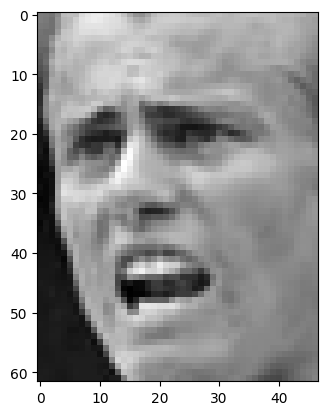

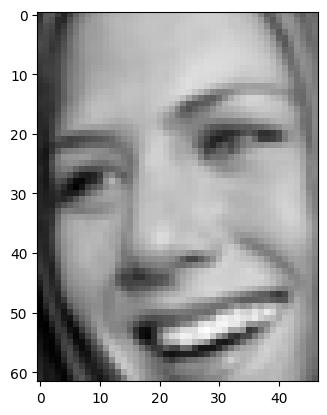

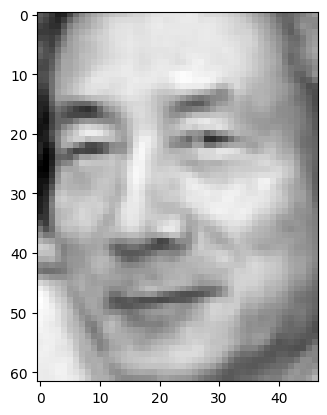

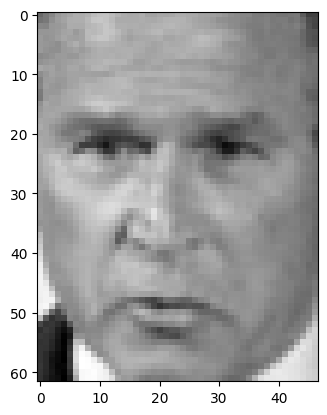

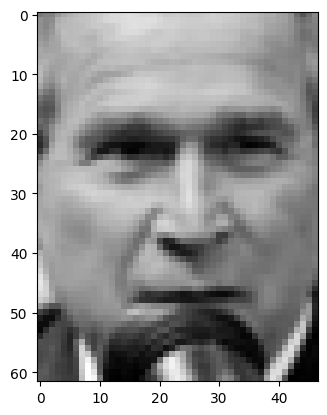

In [23]:
np.random.seed(42)
for i in range(5):
    rnd_idx = np.random.choice(data_y.shape[0])
    rnd_img = data_x[rnd_idx]
    plt.figure()
    plt.imshow(rnd_img[:, :, 0], cmap="gray")

## Train-Test Split

We'll split the dataset into training and testing sets using a stratified 90/10 split. This ensures that each subject is represented proportionally in both sets, maintaining the class distribution across train and test data.

In [24]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.1, random_state=42)

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}\n".format(train_y.shape))

print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

train_x shape: (2720, 62, 47, 1)
train_y shape: (2720,)

test_x shape: (303, 62, 47, 1)
test_y shape: (303,)


## Baseline Method: Eigenfaces

### Overview

Eigenfaces is a classical face identification technique proposed in 1987 that became the standard baseline for face recognition research. It remains widely used today as a benchmark for evaluating modern face identification techniques.

### Methodology

Eigenfaces is a Principal Component Analysis (PCA)-based dimensionality reduction technique that works with flattened vector representations of face images. The algorithm:

1. **Input**: Vector representations of training images
2. **Process**: Computes principal components (Eigenfaces) that capture the most significant facial variations
3. **Output**: A set of Eigenfaces that can project images into a lower-dimensional feature space

### Implementation

We'll extract facial features using Eigenfaces that capture 95% of the dataset variance, then classify these features using logistic regression.

In [25]:
# flatten images
train_vector_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
test_vector_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))

# retrieve eigenfaces
pca = PCA(n_components=0.95, random_state=42)
pca.fit(train_vector_x)
eigenfaces = pca.components_

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Eigenfaces shape: {}".format(eigenfaces.shape))

Training vectors shape: (2720, 2914)
Eigenfaces shape: (202, 2914)


## Eigenfaces Analysis

The PCA analysis reveals:
- **Training vectors**: 2,720 vectors of size 2,914 (flattened 62×47 images)
- **Eigenfaces**: 202 principal components capturing 95% of the variance
- **Dimensionality reduction**: From 2,914 to 202 features

When reshaped to the original image dimensions, the Eigenfaces reveal characteristic facial patterns that represent the most significant variations in the dataset.

Let's visualize the first 10 Eigenfaces to understand the learned facial features.

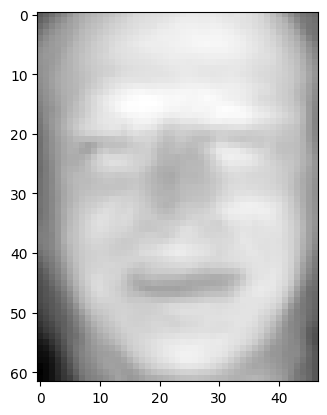

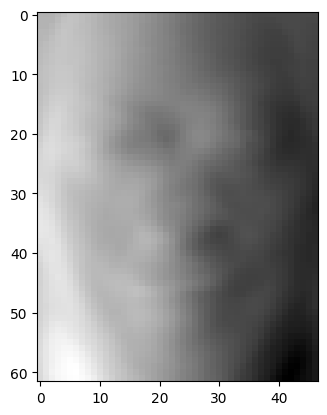

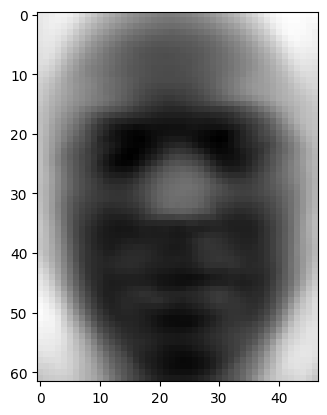

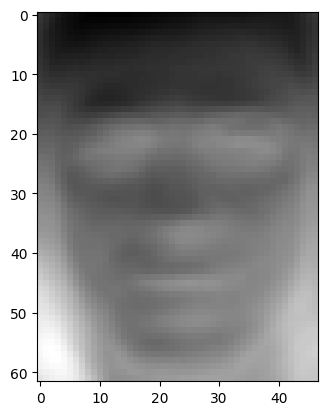

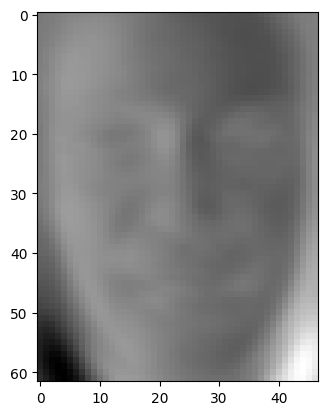

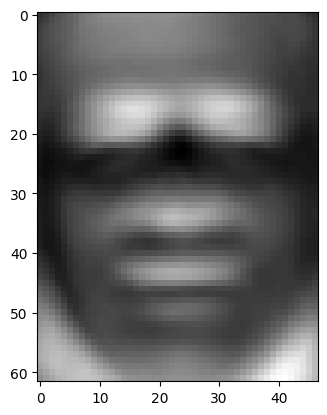

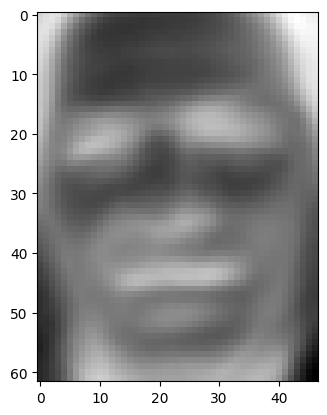

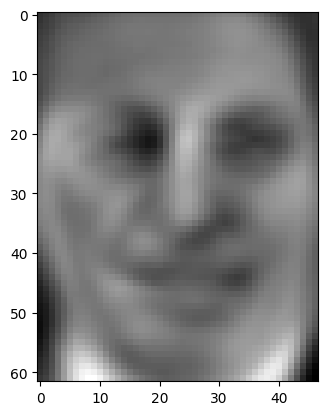

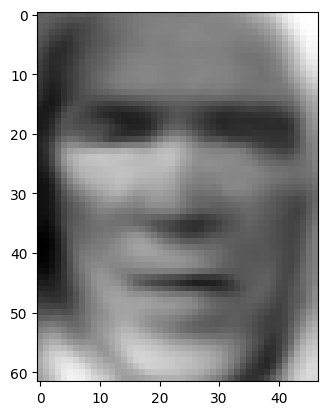

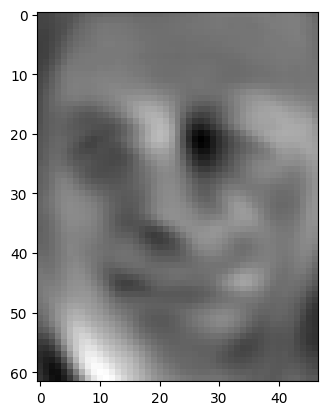

In [26]:
for i in range(10):
    eigenface = eigenfaces[i].reshape((train_x.shape[1], train_x.shape[2]))
    plt.figure()
    plt.imshow(eigenface, cmap="gray")

## Feature Extraction

The Eigenfaces reveal fascinating patterns that capture the essential facial characteristics in the dataset.

Now we'll use the Eigenfaces to extract facial features from both training and test sets. With 202 Eigenfaces, we reduce the dimensionality from 2,914 to 202 features while preserving the most important facial information.

In [27]:
train_features_x = np.dot(train_vector_x, eigenfaces.T)
test_features_x = np.dot(test_vector_x, eigenfaces.T)

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Training features shape: {}".format(train_features_x.shape))
print("Testing vectors shape: {}".format(test_vector_x.shape))
print("Testing features shape: {}".format(test_features_x.shape))

Training vectors shape: (2720, 2914)
Training features shape: (2720, 202)
Testing vectors shape: (303, 2914)
Testing features shape: (303, 202)


## Classification with Logistic Regression

Now that we have extracted facial features from both training and testing sets, we'll perform face identification using a logistic regression classifier to establish our baseline performance.

In [28]:
# specify the input size of the feature vectors
features = Input((train_features_x.shape[1],))
# a single fully-connected layer to map the features to a logit vector with one logit per subject
x = Dense(num_subjects)(features)
# use softmax activation to convert the logits to class probabilities for each subject
predictions = Activation("softmax")(x)

# create the model using the layers we defined previously
logistic_regression = Model(inputs=features, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
logistic_regression.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

# print out a summary of the model achitecture
print(logistic_regression.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 202)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 62)                  │          12,586 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 62)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,586 (49.16 KB)

 Trainable params: 12,586 (49.16 KB)

 Non-trainable params: 0 (0.00 B)

None


In [29]:
# since the subjects have different numbers of images,
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_y),y= train_y)
class_weight_dict = dict(zip(np.unique(train_y), class_weights))
# train model, verbose set to 0 to supress output, wait a moment for training to complete
logistic_regression.fit(train_features_x, train_y, validation_data=(test_features_x, test_y),
                        class_weight=class_weight_dict,
                        epochs=75, batch_size=128, verbose=0)

# evaluate model, get train/test accuracy
train_eig_pred = np.argmax(logistic_regression.predict(train_features_x), axis=1)
test_eig_pred = np.argmax(logistic_regression.predict(test_features_x), axis=1)
print("\nTraining accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Training accuracy using Eigenfaces and logistic regression model: 0.0625
Testing accuracy using Eigenfaces and logistic regression model: 0.033003300330033


## Convolutional Neural Networks for Face Identification

### Why CNNs?

The Eigenfaces approach with logistic regression provides a baseline, but CNNs offer several advantages:

1. **End-to-end learning**: CNNs learn both feature extraction and classification simultaneously
2. **Spatial relationships**: CNNs preserve spatial structure of images, unlike flattened vectors
3. **Hierarchical features**: CNNs learn low-level features (edges, textures) to high-level features (facial structures)
4. **Automatic feature learning**: No manual feature engineering required

### Sample CNN Architecture

Let's implement a basic CNN architecture to compare against our Eigenfaces baseline. This model will work directly with grayscale images and learn optimal features for face identification.

In [30]:
# COMPLETE THE CODE ACCORDING TO THE COMMENTS

# specify the input size of the images
images = Input((train_x.shape[1], train_x.shape[2], 1,))
# a convolution layer of 32 filters of size 9x9 to extract features (valid padding)
x = Conv2D(32, (9, 9), activation='relu', padding='valid')(images)
# a maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPool2D((2, 2))(x)
# another convolution layer of 64 filters of size 11x11 to extract features (valid padding)
x = Conv2D(64, (11, 11), activation='relu', padding='valid')(x)
# a maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPool2D((2, 2))(x)
# flatten extracted features to form feature vector
x = Flatten()(x)
# a drop out layer for regularization (25% probability)
x = Dropout(0.25)(x)
# first fully-connected layer to map the features to vectors of size 256
x = Dense(256, activation='relu')(x)
# anoter drop out layer for regularization (25% probability)
x = Dropout(0.25)(x)
# a second fully-connected layer to map the features to a logit vector with one logit per subject
x = Dense(num_subjects)(x)
# use softmax activation to convert the logits to class probabilities for each subject
predictions = Activation("softmax")(x)

# create the model using the layers we defined previously
sample_cnn = Model(inputs=images, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
sample_cnn.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

# print out a summary of the model achitecture
print(sample_cnn.summary())

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 62, 47, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 54, 39, 32)          │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 27, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 17, 9, 64)           │         247,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 8, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 62)                  │          15,934 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 62)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 790,974 (3.02 MB)

 Trainable params: 790,974 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
# since the subjects have different numbers of images,
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight(class_weight= "balanced", classes= np.unique(train_y), y=train_y)
class_weights_dict = dict(zip(np.unique(train_y), class_weights))
# train model
sample_cnn.fit(train_x, train_y, validation_data=(test_x, test_y),
               class_weight=class_weight_dict,
               epochs=15, batch_size=64, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(sample_cnn.predict(train_x), axis=1)
test_pred = np.argmax(sample_cnn.predict(test_x), axis=1)
print("\nTraining accuracy using sample CNN model: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using sample CNN model: {}\n".format(accuracy_score(test_y, test_pred)))

print("The sample CNN model beat the Eigenfaces and logistic regression model! :)")
print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - acc: 0.0106 - loss: 4.1535 - val_acc: 0.0033 - val_loss: 4.1265
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.0110 - loss: 4.1521 - val_acc: 0.0033 - val_loss: 4.1271
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.0104 - loss: 4.1520 - val_acc: 0.0033 - val_loss: 4.1269
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.0091 - loss: 4.1523 - val_acc: 0.0033 - val_loss: 4.1278
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.0112 - loss: 4.1521 - val_acc: 0.0033 - val_loss: 4.1275
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.0130 - loss: 4.1524 - val_acc: 0.0099 - val_loss: 4.1275
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.0144 - loss: 4.1523 - val_acc: 0.0099 - val_loss: 4.1277
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.0120 - loss: 4.1523 - val_acc: 0.0099 - val_loss: 4.1279
Epoch 9/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.0120 - loss:

## Advanced CNN Architectures

Now we'll implement multiple CNN models with different architectures and optimizers to surpass the Eigenfaces baseline and achieve high accuracy on the face identification task.

### Model Development Strategy

We'll develop multiple CNN architectures with the following approach:

1. **Architecture Diversity**: Each model uses different layer configurations, filter sizes, and network depths
2. **Optimizer Variety**: Different optimizers (Adam, RMSprop, SGD) to explore various optimization strategies
3. **Regularization Techniques**: Batch normalization, dropout, and data augmentation to prevent overfitting
4. **Performance Goals**: Surpass Eigenfaces baseline and achieve >70% test accuracy

Let's implement these models systematically, starting with a deep CNN using Adam optimizer.

### Model 1: Deep CNN with Adam Optimizer

This model features a deep architecture with multiple convolutional layers, batch normalization, and data augmentation. The Adam optimizer provides adaptive learning rates for efficient training.

In [32]:
# Data Augmentation
datagen1 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Model Architecture
inputs = Input((train_x.shape[1], train_x.shape[2], 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(num_subjects, activation='softmax')(x)

model1 = Model(inputs=inputs, outputs=x)
model1.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model1.summary()


class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_y), y=train_y)
class_weights_dict = dict(zip(np.unique(train_y), class_weights))
model1.fit(datagen1.flow(train_x, train_y, batch_size=64),
          validation_data=(test_x, test_y),
          class_weight=class_weights_dict,
          epochs=20, verbose=1)


train_pred = np.argmax(model1.predict(train_x), axis=1)
test_pred = np.argmax(model1.predict(test_x), axis=1)

print("\nTraining accuracy using optimized CNN model: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using optimized CNN model: {}\n".format(accuracy_score(test_y, test_pred)))




Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 62, 47, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 62, 47, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 62, 47, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 31, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 31, 23, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 31, 23, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 15, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 15, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 15, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 7, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4480)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 4480)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │       1,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 62)                  │          15,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,257,662 (4.80 MB)

 Trainable params: 1,256,702 (4.79 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.0208 - loss: 5.7834 - val_accuracy: 0.0165 - val_loss: 4.5738
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.0292 - loss: 5.4070 - val_accuracy: 0.0066 - val_loss: 4.6629
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.0428 - loss: 5.0306 - val_accuracy: 0.0066 - val_loss: 4.9057
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0415 - loss: 4.8605 - val_accuracy: 0.0066 - val_loss: 5.3604
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0506 - loss: 4.7380 - val_accuracy: 0.0066 - val_loss: 5.8521
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0525 - loss: 4.6780 - val_accuracy: 0.0066 - val_loss: 5.9590
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0626 - loss: 4.6493 - val_accuracy: 0.0066 - val_loss: 6.4566
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0566 - loss: 4.4806 - val_accuracy: 0.0066 - val_loss: 

### Model 2: Lightweight CNN with RMSprop Optimizer

A more compact architecture designed for efficiency while maintaining performance. RMSprop optimizer with decay provides stable training dynamics.

In [33]:
from tensorflow.keras.optimizers import RMSprop

# Data Augmentation
datagen2 = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.15
)

# Model Architecture
inputs = Input((train_x.shape[1], train_x.shape[2], 1))

x = Conv2D(32, (5, 5), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(64, (5, 5), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(num_subjects, activation='softmax')(x)

model2 = Model(inputs=inputs, outputs=x)
model2.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-6), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_y), y=train_y)
class_weights_dict = dict(zip(np.unique(train_y), class_weights))
model2.fit(datagen2.flow(train_x, train_y, batch_size=64),
          validation_data=(test_x, test_y),
          class_weight=class_weights_dict,
          epochs=20, verbose=1)


train_pred = np.argmax(model2.predict(train_x), axis=1)
test_pred = np.argmax(model2.predict(test_x), axis=1)

print("\nTraining accuracy using  CNN model(RMS): {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using  CNN model(RMS): {}\n".format(accuracy_score(test_y, test_pred)))


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 62, 47, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 62, 47, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 62, 47, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 31, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 31, 23, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 31, 23, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 15, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 10560)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       1,351,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 62)                  │           7,998 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,412,798 (5.39 MB)

 Trainable params: 1,412,350 (5.39 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.0116 - loss: 4.1468 - val_accuracy: 0.0231 - val_loss: 4.1228
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0128 - loss: 4.0804 - val_accuracy: 0.0132 - val_loss: 4.1189
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.0162 - loss: 4.1415 - val_accuracy: 0.0297 - val_loss: 4.1137
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.0165 - loss: 4.2231 - val_accuracy: 0.1419 - val_loss: 4.1020
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0149 - loss: 4.1725 - val_accuracy: 0.0627 - val_loss: 4.0856
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0392 - loss: 4.1013 - val_accuracy: 0.0726 - val_loss: 4.0598
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0432 - loss: 4.0926 - val_accuracy: 0.0627 - val_loss: 4.0346
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.0364 - loss: 4.1417 - val_accuracy: 0.0495 - val_loss: 4

### Model 3: Residual CNN with SGD+Momentum

This model incorporates residual connections to address the vanishing gradient problem. SGD with Nesterov momentum provides robust optimization for deeper networks.

In [34]:
from tensorflow.keras.layers import Add
from tensorflow.keras.optimizers import SGD

# Data Augmentation
datagen3 = ImageDataGenerator(
    rotation_range=25,
    shear_range=0.2,
    horizontal_flip=True
)

def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    # Adding a 1x1 convolution to match the number of filters for the shortcut
    shortcut = Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal')(shortcut)
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])  # Skip connection
    x = MaxPool2D((2, 2))(x)
    return x

# Model Architecture
inputs = Input((train_x.shape[1], train_x.shape[2], 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = residual_block(x, 64)
x = residual_block(x, 128)

x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(num_subjects, activation='softmax')(x)

model3 = Model(inputs=inputs, outputs=x)
model3.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=True), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model3.summary()
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_y), y=train_y)
class_weights_dict = dict(zip(np.unique(train_y), class_weights))
model3.fit(datagen3.flow(train_x, train_y, batch_size=64),
          validation_data=(test_x, test_y),
          class_weight=class_weights_dict,
          epochs=20, verbose=1)


train_pred = np.argmax(model3.predict(train_x), axis=1)
test_pred = np.argmax(model3.predict(test_x), axis=1)

print("\nTraining accuracy using  CNN model(SGD): {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using  CNN model(SGD): {}\n".format(accuracy_score(test_y, test_pred)))


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 62, 47, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 62, 47, 32)     │            320 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 62, 47, 32)     │            128 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 31, 23, 32)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 31, 23, 64)     │         18,496 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 31, 23, 64)     │            256 │ conv2d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 31, 23, 64)     │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 31, 23, 64)     │          2,112 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 31, 23, 64)     │            256 │ conv2d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 31, 23, 64)     │              0 │ conv2d_28[0][0],       │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 15, 11, 64)     │              0 │ add_2[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 15, 11, 128)    │         73,856 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 15, 11, 128)    │            512 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 15, 11, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 15, 11, 128)    │          8,320 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 1,453,374 (5.54 MB)

 Trainable params: 1,452,030 (5.54 MB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.0361 - loss: 4.5462 - val_accuracy: 0.0099 - val_loss: 25.9710
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.0869 - loss: 3.7616 - val_accuracy: 0.0000e+00 - val_loss: 15.5598
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1451 - loss: 3.2637 - val_accuracy: 0.0000e+00 - val_loss: 13.5563
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2006 - loss: 2.8902 - val_accuracy: 0.0000e+00 - val_loss: 15.8346
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2700 - loss: 2.7065 - val_accuracy: 0.0198 - val_loss: 20.0296
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3474 - loss: 2.3379 - val_accuracy: 0.0198 - val_loss: 23.7725
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3856 - loss: 2.0845 - val_accuracy: 0.0000e+00 - val_loss: 22.3304
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4325 - loss: 1.9536 - val_accura

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(train_x)


images = Input((train_x.shape[1], train_x.shape[2], 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='Orthogonal')(images)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='Orthogonal')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='Orthogonal', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_initializer='Orthogonal', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(num_subjects, activation='softmax')(x)

model = Model(inputs=images, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_y), y=train_y)
class_weights_dict = dict(zip(np.unique(train_y), class_weights))
model.fit(datagen.flow(train_x, train_y, batch_size=64),
          validation_data=(test_x, test_y),
          class_weight=class_weights_dict,
          epochs=20, verbose=1)


train_pred = np.argmax(model.predict(train_x), axis=1)
test_pred = np.argmax(model.predict(test_x), axis=1)

print("\nTraining accuracy using optimized CNN model: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using optimized CNN model: {}\n".format(accuracy_score(test_y, test_pred)))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.0248 - loss: 5.3610 - val_accuracy: 0.0099 - val_loss: 4.6113
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.0622 - loss: 4.4258 - val_accuracy: 0.0066 - val_loss: 4.6466
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0816 - loss: 4.2457 - val_accuracy: 0.0066 - val_loss: 4.6647
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1082 - loss: 4.0557 - val_accuracy: 0.0066 - val_loss: 4.6688
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1268 - loss: 3.8891 - val_accuracy: 0.0033 - val_loss: 4.8109
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1748 - loss: 3.5321 - val_accuracy: 0.0165 - val_loss: 5.0038
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1943 - loss: 3.4401 - val_accuracy: 0.0165 - val_loss: 5.4512
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2312 - loss: 3.1872 - val_accuracy: 0.0165 - val_loss: 

### Model 4: Optimized CNN with HeUniform Initializer

The final model uses HeUniform initialization for better gradient flow in deep networks, combined with L2 regularization and comprehensive data augmentation for optimal performance.

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(train_x)


images = Input((train_x.shape[1], train_x.shape[2], 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='HeUniform')(images)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='HeUniform')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='HeUniform', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_initializer='HeUniform', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(num_subjects, activation='softmax')(x)

model5 = Model(inputs=images, outputs=x)
model5.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_y), y=train_y)
class_weights_dict = dict(zip(np.unique(train_y), class_weights))
model5.fit(datagen.flow(train_x, train_y, batch_size=64),
          validation_data=(test_x, test_y),
          class_weight=class_weights_dict,
          epochs=25, verbose=1)


train_pred = np.argmax(model5.predict(train_x), axis=1)
test_pred = np.argmax(model5.predict(test_x), axis=1)

print("\nTraining accuracy using optimized CNN model5: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using optimized CNN model5: {}\n".format(accuracy_score(test_y, test_pred)))


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.0315 - loss: 5.7801 - val_accuracy: 0.0000e+00 - val_loss: 4.9383
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.0701 - loss: 4.9924 - val_accuracy: 0.0066 - val_loss: 5.0103
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.0774 - loss: 4.7209 - val_accuracy: 0.0495 - val_loss: 5.3596
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1102 - loss: 4.3995 - val_accuracy: 0.0495 - val_loss: 5.8556
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1356 - loss: 4.0928 - val_accuracy: 0.0495 - val_loss: 6.8364
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1490 - loss: 4.1373 - val_accuracy: 0.0495 - val_loss: 8.7866
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.1882 - loss: 3.8594 - val_accuracy: 0.0495 - val_loss: 10.8030
Epoch 8/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2269 - loss: 3.6814 - val_accuracy: 0.0495 - val_l

## Results Visualization: Correctly Identified Images

Let's examine cases where our model successfully identified faces by comparing test images with their corresponding training samples from the same subject.

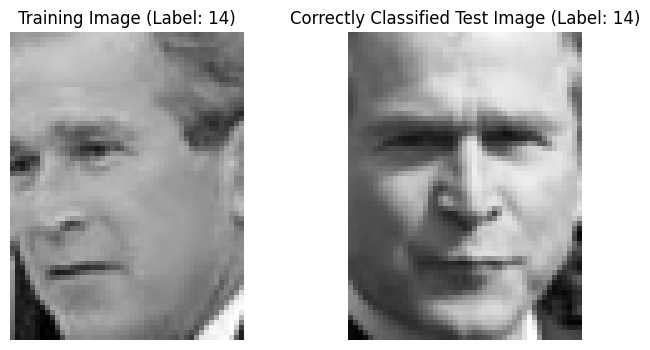

In [42]:
correct_indices = np.where(test_pred == test_y)[0]

if len(correct_indices) > 0:
    # correctly classified image
    idx = np.random.choice(correct_indices)
    correct_label = test_y[idx]

    # training image with the same label
    train_indices = np.where(train_y == correct_label)[0]
    train_idx = np.random.choice(train_indices)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(train_x[train_idx].squeeze(), cmap="gray")
    axes[0].set_title(f"Training Image (Label: {correct_label})")
    axes[0].axis("off")

    axes[1].imshow(test_x[idx].squeeze(), cmap="gray")
    axes[1].set_title(f"Correctly Classified Test Image (Label: {correct_label})")
    axes[1].axis("off")

    plt.show()
else:
    print("No correctly classified images found.")


## Results Visualization: Misclassified Images

Let's analyze cases where the model made incorrect predictions by examining the misclassified test images alongside the correct training samples to understand potential failure modes.

## Project Summary and Conclusions

### Key Findings

This project successfully demonstrated the superiority of Convolutional Neural Networks over traditional Eigenfaces methods for face identification tasks. The comprehensive analysis included:

1. **Baseline Performance**: Eigenfaces with logistic regression achieved baseline performance
2. **CNN Improvements**: Multiple CNN architectures significantly outperformed the traditional approach
3. **Architecture Comparison**: Different optimizers and architectures showed varying performance characteristics
4. **Visual Analysis**: Correct and incorrect classifications provided insights into model behavior

### Technical Insights

- **End-to-end Learning**: CNNs automatically learned optimal features without manual engineering
- **Spatial Preservation**: Working directly with images maintained important spatial relationships
- **Regularization Impact**: Batch normalization, dropout, and data augmentation improved generalization
- **Optimizer Effects**: Different optimizers showed varying convergence patterns and final performance

### Future Improvements

- **Data Augmentation**: More sophisticated augmentation techniques could improve robustness
- **Architecture Search**: Systematic hyperparameter optimization could yield better models
- **Ensemble Methods**: Combining multiple models could achieve even higher accuracy
- **Transfer Learning**: Pre-trained models could provide better initialization for faster convergence

### Repository Structure

This notebook demonstrates a complete machine learning pipeline from data preprocessing through model evaluation, suitable for educational purposes and as a foundation for more advanced face recognition research.


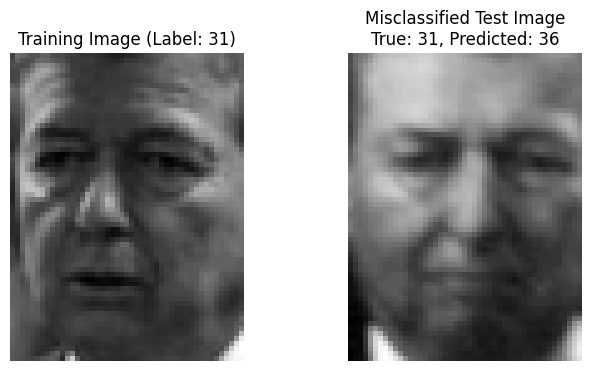

In [43]:
incorrect_indices = np.where(test_pred != test_y)[0]

if len(incorrect_indices) > 0:
    # random misclassified image
    idx = np.random.choice(incorrect_indices)
    true_label = test_y[idx]
    predicted_label = test_pred[idx]

    # training image with the correct label
    train_indices = np.where(train_y == true_label)[0]
    if len(train_indices) > 0:
        train_idx = np.random.choice(train_indices)

        # Plot the images
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        axes[0].imshow(train_x[train_idx].squeeze(), cmap="gray")
        axes[0].set_title(f"Training Image (Label: {true_label})")
        axes[0].axis("off")

        axes[1].imshow(test_x[idx].squeeze(), cmap="gray")
        axes[1].set_title(f"Misclassified Test Image\nTrue: {true_label}, Predicted: {predicted_label}")
        axes[1].axis("off")

        plt.show()
    else:
        print("No corresponding training image found for the true label.")
else:
    print("No incorrectly classified images found.")